In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import numpy as np
import pandas as pd
import sdata
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))
import database as db

Autosave disabled


03:17:45 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:cc499a3bbc7e4379b8a4a156d2f591f9
n01:7e39d4e9f56b468e81ad116e8538d504
[n0:cc499a3bbc7e4379b8a4a156d2f591f9, n01:7e39d4e9f56b468e81ad116e8538d504, n02:2b4c9adc24a741fd96600dfd0c1a8090, n011:06390709ce624b71bdbddb6d8318a7df, n012:c891d5853e3a49a4af8413ed1f918674]


## initialize db

In [4]:
db_path = "/tmp/test_uuid.sqlite"
if os.path.exists(db_path):
    os.remove(db_path)
db.initialize(db_path)

## add nodes

In [5]:
for node in nodes:
    db.atomic(db_path, db.add_node(node.data, node.uuid))

## add edges

In [6]:
for node in nodes:
    print("{} -> {}".format(node.parent, node.uuid))
    if node.parent is not None and node.uuid is not None:
        db.atomic(db_path, db.connect_nodes(node.parent, node.uuid, {'parent': node.parent}))


None->cc499a3bbc7e4379b8a4a156d2f591f9
cc499a3bbc7e4379b8a4a156d2f591f9->7e39d4e9f56b468e81ad116e8538d504
cc499a3bbc7e4379b8a4a156d2f591f9->2b4c9adc24a741fd96600dfd0c1a8090
7e39d4e9f56b468e81ad116e8538d504->06390709ce624b71bdbddb6d8318a7df
7e39d4e9f56b468e81ad116e8538d504->c891d5853e3a49a4af8413ed1f918674


## get node by uuid

In [7]:
rn0 = db.atomic(db_path, db.find_node(n0.uuid))
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': 'cc499a3bbc7e4379b8a4a156d2f591f9', '!parent': None, 'id': 'cc499a3bbc7e4379b8a4a156d2f591f9'}


## get all nodes

In [8]:
db.atomic(db_path, db.find_nodes({'name': ''}, db._search_like, db._search_starts_with))

[{'name': 'n0',
  'uuid': 'cc499a3bbc7e4379b8a4a156d2f591f9',
  '!parent': None,
  'id': 'cc499a3bbc7e4379b8a4a156d2f591f9'},
 {'name': 'n01',
  'uuid': '7e39d4e9f56b468e81ad116e8538d504',
  '!parent': 'cc499a3bbc7e4379b8a4a156d2f591f9',
  'id': '7e39d4e9f56b468e81ad116e8538d504'},
 {'name': 'n02',
  'uuid': '2b4c9adc24a741fd96600dfd0c1a8090',
  '!parent': 'cc499a3bbc7e4379b8a4a156d2f591f9',
  'id': '2b4c9adc24a741fd96600dfd0c1a8090'},
 {'name': 'n011',
  'uuid': '06390709ce624b71bdbddb6d8318a7df',
  '!parent': '7e39d4e9f56b468e81ad116e8538d504',
  'id': '06390709ce624b71bdbddb6d8318a7df'},
 {'name': 'n012',
  'uuid': 'c891d5853e3a49a4af8413ed1f918674',
  '!parent': '7e39d4e9f56b468e81ad116e8538d504',
  'id': 'c891d5853e3a49a4af8413ed1f918674'}]

In [9]:
rn011 = db.atomic(db_path, db.find_node(n011.uuid))
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': '06390709ce624b71bdbddb6d8318a7df', '!parent': '7e39d4e9f56b468e81ad116e8538d504', 'id': '06390709ce624b71bdbddb6d8318a7df'}


In [10]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [11]:
ids = [n.uuid for n in nodes]
# print(ids)

dotstr = db.get_dot(db_path, path=ids)
# print("!", dotstr)

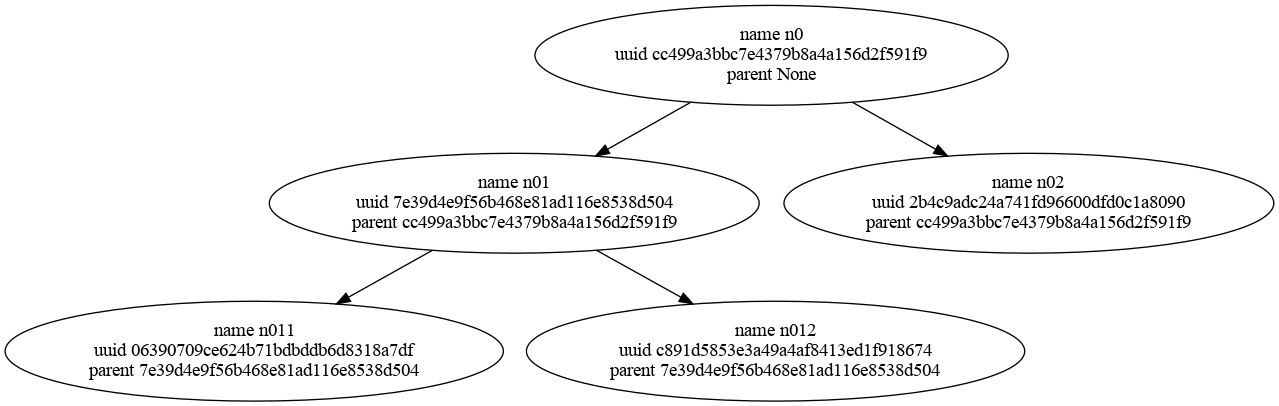

In [12]:
draw(dotstr)
